# Hierarchical Models

This chapter continues from where the last one ended and explores more varieties of hierarchical models. Here I've explored npxG/Shot as the means to modify the priors using regression. There is definitely a strong correlation between the two which is not unsurprising to me at all.



What's not entirely clear to me is whether this should be used as an input to modify the priors. I could probably argue for, but would wait for more expert opinions.

In [1]:
%load_ext autoreload
%autoreload 2

from scipy.interpolate import CubicSpline, BSpline
import scipy.special as special
from scipy.stats import beta,binom,chi2_contingency,gaussian_kde,rv_continuous,norm,rv_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import numpy.typing as npt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 50)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])
df['a'] = df['npG'] + bf[0]
df['b'] = df['Shots'] + bf[1] - df['npG']
df.rename(columns = {'90s':'Nineties'},inplace=True)
df['npxG/Shot'] = df['npxG']/df['Shots']
df['Shots/90'] = df['Shots']/df['Nineties']

In [2]:
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,npxG/Shot,Shots/90
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085783,8.648493,92.169808,0.114286,2.571429
1,Aaron Cresswell (1989),133.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074673,8.648493,107.169808,0.050000,0.586466
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096090,10.648493,100.169808,0.136986,2.039106
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077265,10.648493,127.169808,0.055000,1.201923
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111123,19.648493,157.169808,0.123022,2.308970


## Absolute Volume

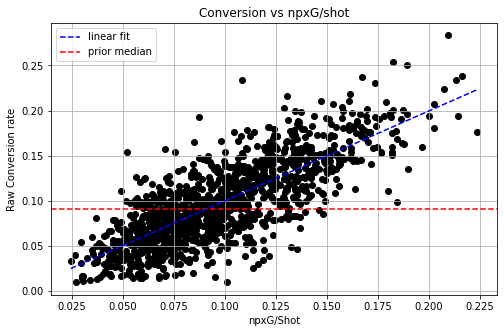

In [3]:
def plot_fit(qty1,qty2,xlabel,ylabel,title,ax):
    x = (df[qty1].values.reshape(-1,1))
    y = (df[qty2].values)
    model = LinearRegression().fit(x,y)
    intc, slope = model.intercept_, model.coef_
    X = np.linspace(df[qty1].min(), df[qty1].max(), 100)
    Y = slope*(X) + intc
    ax.scatter(df[qty1], df[qty2], color='k')
    ax.plot(X, Y, color = 'b', ls='--',zorder=3, label='linear fit')
    ax.axhline(df.Conv.median(), color='r', ls = '--', zorder=2, label = 'prior median')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid();
    ax.legend();
fig, ax = plt.subplots(figsize=(8,5))
plot_fit('npxG/Shot', 'Conv', 'npxG/Shot', 'Raw Conversion rate','Conversion vs npxG/shot',ax)

In [4]:
def BBLL1(params,Y,X):
    N = df.Shots.values
    mu0, mu1, phi = params
    mu = special.expit(mu0 + mu1*X) 
    a = mu*phi
    b = (1-mu)*phi
    t1 = special.loggamma(N+1+1e-15) - special.loggamma(Y+1+1e-15) - special.loggamma(N-Y+1+1e-15)  
    t2 = special.loggamma(Y+a+1e-15) + special.loggamma(N-Y+b+1e-15) - special.loggamma(N+a+b+1e-15)
    t3 = special.loggamma(a+b+1e-15) - special.loggamma(a+1e-15) - special.loggamma(b+1e-15)
    total = -np.sum(t1 + t2 + t3)
    return total
res = minimize(BBLL1, x0=[0,0,100], args=(df.npG.values,df['npxG/Shot'].values),
               bounds=[(None,None),(None,None),(0,None)])
mu0, mu1 = res.x[:-1]
sigma0 = 1/res.x[-1]

df['new_a'] = special.expit(mu0 + mu1*df['npxG/Shot'])/sigma0 + df['npG']
df['new_b'] = (1 - special.expit(mu0 + mu1*df['npxG/Shot']))/sigma0 + df['Shots'] - df['npG']
df['new_Conv'] = df['new_a']/(df['new_a'] + df['new_b'])
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,npxG/Shot,Shots/90,new_a,new_b,new_Conv
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085783,8.648493,92.169808,0.114286,2.571429,90.839154,747.838773,0.108312
1,Aaron Cresswell (1989),133.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074673,8.648493,107.169808,0.050000,0.586466,51.393793,802.284135,0.060203
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096090,10.648493,100.169808,0.136986,2.039106,112.660831,736.017096,0.132749
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077265,10.648493,127.169808,0.055000,1.201923,55.722901,819.955027,0.063634
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111123,19.648493,157.169808,0.123022,2.308970,109.050149,805.627779,0.119222


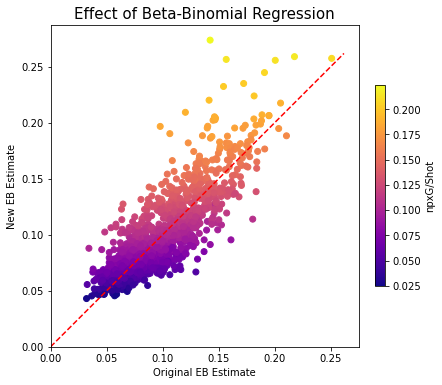

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.scatter(df.Eb_Conv, df.new_Conv, c=df['npxG/Shot'], cmap=mpl.cm.plasma);
ax.plot(np.linspace(0, ax.get_xlim()[1],100), np.linspace(0, ax.get_xlim()[1],100), color='red', linestyle='--')
ax.set_aspect('equal')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Original EB Estimate')
ax.set_ylabel('New EB Estimate')
fig.colorbar(im, ax=ax, fraction=.03).set_label('npxG/Shot');
ax.set_title('Effect of Beta-Binomial Regression', fontsize = 15);

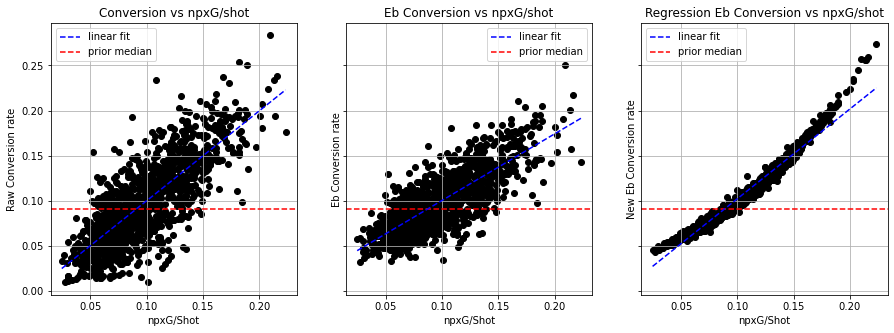

In [6]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3,sharey=True)
plot_fit('npxG/Shot', 'Conv', 'npxG/Shot', 'Raw Conversion rate','Conversion vs npxG/shot',ax[0])
plot_fit('npxG/Shot', 'Eb_Conv', 'npxG/Shot', 'Eb Conversion rate','Eb Conversion vs npxG/shot',ax[1])
plot_fit('npxG/Shot', 'new_Conv', 'npxG/Shot', 'New Eb Conversion rate','Regression Eb Conversion vs npxG/shot',ax[2])

This definitely seems like a pretty strong signal. Meesa like this. 

## Shots/90

Okay, next up, I once again want to revisit using shots to modify $mu$. But this time I will go with shots per 90 instead of the absolute volume. Let's see what happens....fingers crossed.

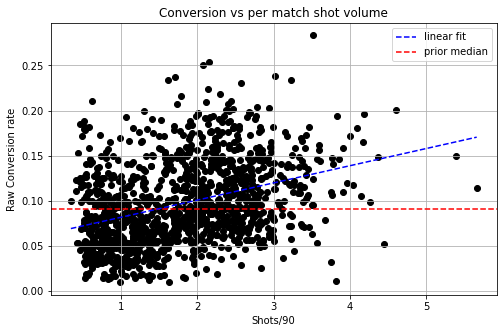

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
plot_fit('Shots/90', 'Conv', 'Shots/90', 'Raw Conversion rate','Conversion vs per match shot volume',ax)

There seems to be some signal here, but maybe not an awful lot. Let's plough on and do the regression and check what happens with the shrinkage.

In [8]:
res = minimize(BBLL1, x0=[0,0,100], args=(df.npG.values,df['Shots/90'].values),
               bounds=[(None,None),(None,None),(0,None)])
mu0, mu1 = res.x[:-1]
sigma0 = 1/res.x[-1]

df['new_a'] = special.expit(mu0 + mu1*df['Shots/90'])/sigma0 + df['npG']
df['new_b'] = (1 - special.expit(mu0 + mu1*df['Shots/90']))/sigma0 + df['Shots'] - df['npG']
df['new_Conv'] = df['new_a']/(df['new_a'] + df['new_b'])
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,npxG/Shot,Shots/90,new_a,new_b,new_Conv
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085783,8.648493,92.169808,0.114286,2.571429,16.128553,146.851160,0.098960
1,Aaron Cresswell (1989),133.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074673,8.648493,107.169808,0.050000,0.586466,12.634568,165.345145,0.070989
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096090,10.648493,100.169808,0.136986,2.039106,17.073589,155.906124,0.098703
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077265,10.648493,127.169808,0.055000,1.201923,15.593814,184.385899,0.077977
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111123,19.648493,157.169808,0.123022,2.308970,26.596834,212.382879,0.111293


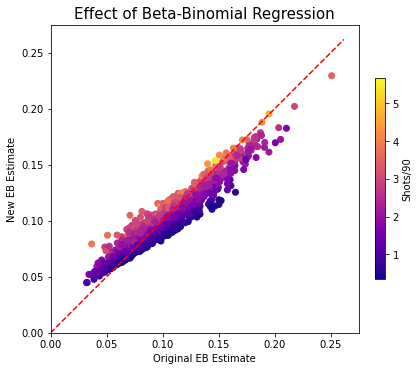

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.scatter(df.Eb_Conv, df.new_Conv, c=df['Shots/90'], cmap=mpl.cm.plasma);
ax.plot(np.linspace(0, ax.get_xlim()[1],100), np.linspace(0, ax.get_xlim()[1],100), color='red', linestyle='--')
ax.set_aspect('equal')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Original EB Estimate')
ax.set_ylabel('New EB Estimate')
fig.colorbar(im, ax=ax, fraction=.03).set_label('Shots/90');
ax.set_title('Effect of Beta-Binomial Regression', fontsize = 15);

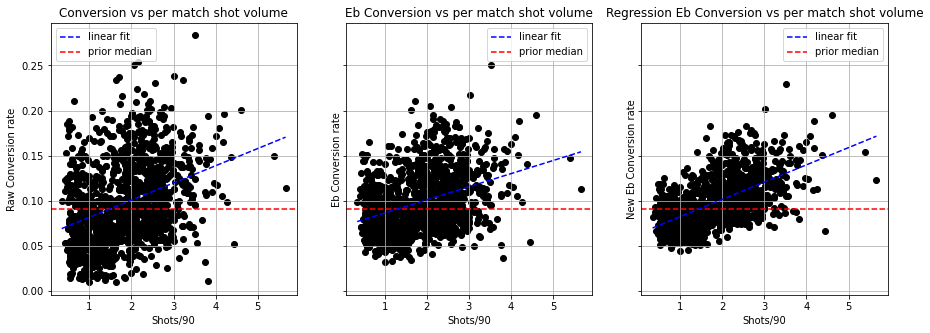

In [10]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3,sharey=True)
plot_fit('Shots/90', 'Conv', 'Shots/90', 'Raw Conversion rate','Conversion vs per match shot volume',ax[0])
plot_fit('Shots/90', 'Eb_Conv', 'Shots/90', 'Eb Conversion rate','Eb Conversion vs per match shot volume',ax[1])
plot_fit('Shots/90', 'new_Conv', 'Shots/90', 'New Eb Conversion rate',
         'Regression Eb Conversion vs per match shot volume',ax[2])

Hmm....looks very similar to the shot volume regression plots....maybe a bit stronger of an effect than the overall volume.

Ok, I am happy to move on from shot volume (per match or overall). Let's try something interesting now - age effect. Pretty much everyone would agree that Father Time comes for all no matter the sport and no matter the sportsperson (even Erioh Kure). Some do age like (self-proclaimed) fine-wine *cough* *cough* Zlatan, but the overall trend is indicative of a prime, a pre-prime and post-prime (kind rephrasing for retirement).

We have fbref data from 2017-18 to 2021-22, but aggregate, so we are going to use the current age of players in this era to determine age effects. Note that this suffers from two issues - (a) we don't get an age curve here really....only one single number for each player. Ideally we would like to look at players' performances over the years to understand the effect of aging. (b) There could be players who stopped playing in 2017-18, but their average age would be a bit higher since we are taking a 5 year period into account. Both issues are fixable if I scraped the data accordingly, but I will keep that aside for a later chapter. Let's just do a rough age effect estimate here.

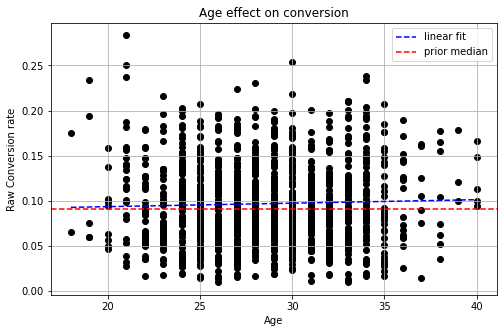

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
plot_fit('Age', 'Conv', 'Age', 'Raw Conversion rate','Age effect on conversion',ax)

Welp...not much of a pattern, is it ?!! I can see some nice oscillations, but no indication that conversion rate enjoys a prime. Or maybe, wait a second...this could be suffering small sample effects, or selection bias, especially below 20 and above 36. We could group those players into two groups, under 21 and over 36 and replot.

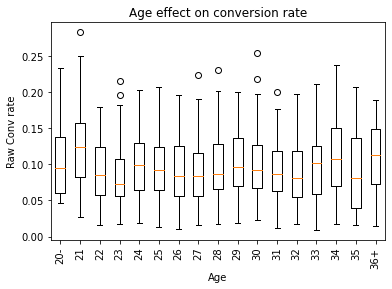

In [12]:
df['dummyAge'] = np.where(df.Age<=20, 20, np.where(df.Age>=36,36,df.Age))
data = [df[df.dummyAge==i].Conv.tolist() for i in range(20,37)]
fig, ax = plt.subplots()
ax.set_title('Age effect on conversion rate');
bp = ax.boxplot(data);
ax.set_xticklabels(['20-']+[str(21+i) for i in range(15)]+['36+'], rotation=90);
ax.set_xlabel('Age');
ax.set_ylabel('Raw Conv rate');

Yeah, well....meh-ish oscillations all around. There is a "prime" at 21, and there is Zlatan at 36+. Can't say much beyond that. We will model this with a cubic spline following David.

In [23]:
k = 3
t = [0, 1, 2, 3, 4, 5, 6, 7]
def BBLL1(params,Y,X):
    N = df.Shots.values
    mu0, phi = params[:2]
    c = params[2:]
    spl = BSpline(t,c,k)
    mu = special.expit(mu0 + spl(X)) 
    a = mu*phi
    b = (1-mu)*phi
    t1 = special.loggamma(N+1+1e-15) - special.loggamma(Y+1+1e-15) - special.loggamma(N-Y+1+1e-15)  
    t2 = special.loggamma(Y+a+1e-15) + special.loggamma(N-Y+b+1e-15) - special.loggamma(N+a+b+1e-15)
    t3 = special.loggamma(a+b+1e-15) - special.loggamma(a+1e-15) - special.loggamma(b+1e-15)
    total = -np.sum(t1 + t2 + t3)
    return total
res = minimize(BBLL1, x0=[0,100,1,1,1,1], args=(df.npG.values,df['dummyAge'].values),
               bounds=[(None,None),(0,None),(None,None),(None,None),(None,None),(None,None)])
mu0 = res.x[0]
sigma0 = 1.0/res.x[1]
c0 = res.x[2:]
spl = BSpline(t,c0,k)

df['new_a'] = special.expit(mu0 + spl(df['dummyAge']))/sigma0 + df['npG']
df['new_b'] = (1 - special.expit(mu0 + spl(df['dummyAge'])))/sigma0 + df['Shots'] - df['npG']
df['new_Conv'] = df['new_a']/(df['new_a'] + df['new_b'])
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,npxG/Shot,Shots/90,new_a,new_b,new_Conv,dummyAge
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085783,8.648493,92.169808,0.114286,2.571429,22.021266,140.978694,0.135100,21.0
1,Aaron Cresswell (1989),133.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074673,8.648493,107.169808,0.050000,0.586466,13.799289,164.200671,0.077524,32.0
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096090,10.648493,100.169808,0.136986,2.039106,18.400922,154.599038,0.106364,24.0
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077265,10.648493,127.169808,0.055000,1.201923,15.272305,184.727655,0.076362,31.0
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111123,19.648493,157.169808,0.123022,2.308970,24.272305,214.727655,0.101558,31.0


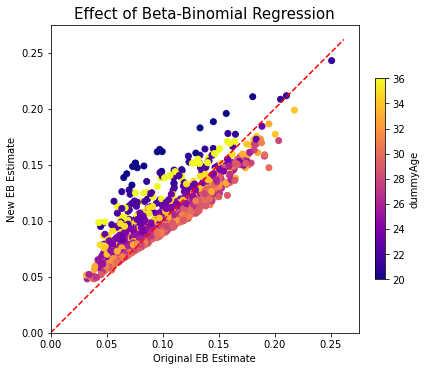

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.scatter(df.Eb_Conv, df.new_Conv, c=df['dummyAge'], cmap=mpl.cm.plasma);
ax.plot(np.linspace(0, ax.get_xlim()[1],100), np.linspace(0, ax.get_xlim()[1],100), color='red', linestyle='--')
ax.set_aspect('equal')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Original EB Estimate')
ax.set_ylabel('New EB Estimate')
fig.colorbar(im, ax=ax, fraction=.03).set_label('dummyAge');
ax.set_title('Effect of Beta-Binomial Regression', fontsize = 15);

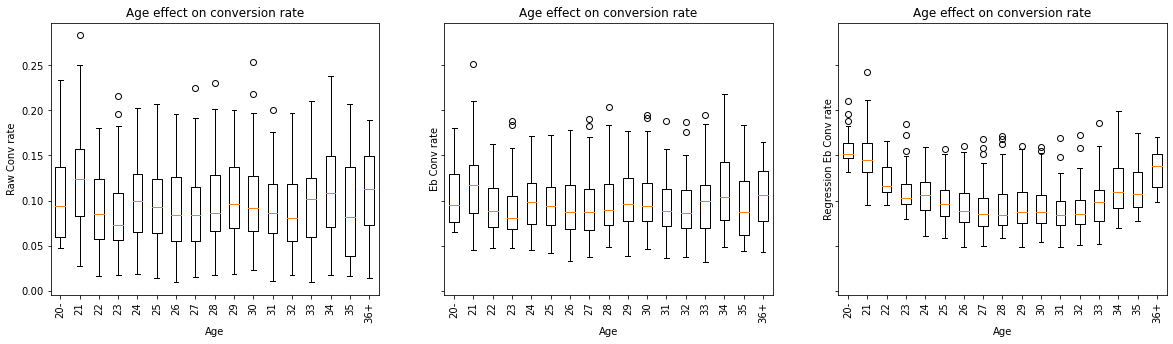

In [31]:
data1 = [df[df.dummyAge==i].Conv.tolist() for i in range(20,37)]
data2 = [df[df.dummyAge==i].Eb_Conv.tolist() for i in range(20,37)]
data3 = [df[df.dummyAge==i].new_Conv.tolist() for i in range(20,37)]
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,5),sharey=True)
ax[0].set_title('Age effect on conversion rate');
ax[0].boxplot(data1);
ax[0].set_xticklabels(['20-']+[str(21+i) for i in range(15)]+['36+'], rotation=90);
ax[0].set_xlabel('Age');
ax[0].set_ylabel('Raw Conv rate');
ax[1].set_title('Age effect on conversion rate');
ax[1].boxplot(data2);
ax[1].set_xticklabels(['20-']+[str(21+i) for i in range(15)]+['36+'], rotation=90);
ax[1].set_xlabel('Age');
ax[1].set_ylabel('Eb Conv rate');
ax[2].set_title('Age effect on conversion rate');
ax[2].boxplot(data3);
ax[2].set_xticklabels(['20-']+[str(21+i) for i in range(15)]+['36+'], rotation=90);
ax[2].set_xlabel('Age');
ax[2].set_ylabel('Regression Eb Conv rate');

These box plots really highlight the difference between the three estimates of conversion rates. The most interesting of the three is definitely the last plot, representing the regression Eb conversion rate.

I think it's overestimating in a way that I think is ultimately wrong, but it's for the right reasons.

There's lots of young and old players that won't be good, they're just not getting minutes. Whereas players in their primes will be less likely to be content sitting on the bench (or not even in the squad). The issue is that the data is victim to selection bias, and this is skewing the results.

The analysis is good, but the data is inherently skewed in a way that is flawed.